# Heatwave hazard assessment using EuroHEAT methodology

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [HEATWAVES](https://github.com/CLIMAAX/HEATWAVES) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

## Description of the assessment

### Heatwave based on the EuroHEAT project approach

The heatwave hazard assessment presented in this page is directly based on an existing [dataset of heat wave days on CDS](https://cds.climate.copernicus.eu/datasets/sis-heat-and-cold-spells?tab=overview).
This notebook provides an example on how to extract this data for any grid cell of the dataset (resolution of 12 x 12 km) in the EU.

<figure class="align-center">
  <iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/_GGFbEtiYBU?si=PFC88WRs_mW0e4ny" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>
</figure>

The methodology is based on a dataset from the EuroHEAT project with two options for defining heatwaves:

- **Health-related EU-wide definition:** for the summer period of June to August, heat waves were defined as days in which the maximum apparent temperature (Tappmax) exceeds the threshold (90th percentile of Tappmax for each month) and the minimum temperature (Tmin) exceeds its threshold (90th percentile of Tmin for each month) for at least two days. The apparent temperature is a measure of relative discomfort due to combined heat and high humidity, developed based on physiological studies on evaporative skin cooling. It can be calculated as a combination of air and dew point temperature.
- **National heat-wave definition**: each nation uses a different methodology e.g. for Belgium, a heatwave-day is a day on which both the three-day running daily minimum and maximum temperature exceeds a threshold of 18.2 °C and 29.6 °C between April and September. This condition has to be met for three consecutive days. For this example, the source of the heat wave definition is the Belgian federal public health agency. See [this page](https://confluence.ecmwf.int/display/CKB/Heat+waves+and+cold+spells+in+Europe+derived+from+climate+projections+documentation) for more national definitions.


#### Advantages of using this methodology and dataset

- Pre-computed indicators - less data that needs to be downloaded and processed (in comparison with the Peseta-IV and Xclim hazard workflows). 
- Data available on a 12x12km grid for years 1986-2085 for the whole EU.
- The heatwave definition is based on both maximum and minimum daily temperatures, so it accounts for the effect of minimum temperature on the severity of a heat wave (e.g. when temperature significantly drops during the nights thus making the heatwave less severe).
  
#### Disadvantages

- No possibility of changing thresholds for temperature and number of days in the heatwave definition.
- Only contains values aggregated per year.
- National heat wave definitions are not available for all EU states (only a selection). 

## Step 1: Preparation work

### Import packages

:::{admonition} Find out more about the libraries used in this workflow:
:class: hint dropdown
* [zipfile](https://docs.python.org/3/library/zipfile.html) - Provides tools for creating, reading, writing, and extracting ZIP files.
* [os](https://docs.python.org/3/library/os.html) - Provides functions for interacting with the operating system, such as file and directory manipulation.
* [cdsapi](https://cds.climate.copernicus.eu/how-to-api) - A library to request data from the datasets listed in the CDS catalogue.
* [numpy](https://numpy.org/doc/stable/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
* [xarray](https://docs.xarray.dev/en/stable/) - Introduces labels in the form of dimensions, coordinates, and attributes on top of raw NumPy-like arrays for a more intuitive experience.
* [rasterio](https://rasterio.readthedocs.io/en/latest/) - A library for reading and writing geospatial raster data.
* [plotly](https://plotly.com/) - A Python Graphing Library.
* [ipyleaflet](https://ipyleaflet.readthedocs.io/en/stable/) - Enables interactive maps in Jupyter notebooks using the Leaflet.js library.
* [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) - Provides interactive HTML widgets for Jupyter notebooks.
* [localtileserver](https://localtileserver.readthedocs.io/en/latest/) - Serves local raster tiles for visualization n Leaflet maps.


In [1]:
import os
import zipfile

import cdsapi
import numpy as np
import xarray as xr
import plotly.graph_objects as go
from ipyleaflet import Map, DrawControl, Marker, LayersControl
import ipywidgets as widgets
from localtileserver import get_leaflet_tile_layer, TileClient
from IPython.display import display

In [2]:
# Set host forwarding for remote jupyterlab sessions
if 'JUPYTERHUB_SERVICE_PREFIX' in os.environ:
    os.environ['LOCALTILESERVER_CLIENT_PREFIX'] = f"{os.environ['JUPYTERHUB_SERVICE_PREFIX']}/proxy/{{port}}"

### Create a directory structure

In [3]:
# Define the directory for storing data
workflow_folder = 'Heatwave_hazard_EuroHEAT'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(data_dir))
    os.makedirs(os.path.join(results_dir))

## Step 2: Retrieving data on heat wave occurence

### Download data from the CDS

You can download data from the CDS with the API.
If this is the first time you do this, you will need to register on CDS and set your API key.
Check the [CDSAPI setup](https://cds.climate.copernicus.eu/how-to-api) page for more information.

In [4]:
URL = "https://cds.climate.copernicus.eu/api"
KEY = None # put here your key!

c = cdsapi.Client(url=URL, key=KEY)

#### Downloading the health-related dataset from EuroHEAT [[source](https://cds.climate.copernicus.eu/datasets/sis-heat-and-cold-spells?tab=download)]

In [5]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'heat_spells_health_1986_2085.zip')

# Heat waves and cold spells in Europe derived from climate projections
c.retrieve(
    'sis-heat-and-cold-spells',
    {
        'variable': 'heat_wave_days',
        'definition': 'health_related',
        'experiment': [
            'rcp4_5', 'rcp8_5',
        ],
        'ensemble_statistic': [
            'ensemble_members_average', 'ensemble_members_standard_deviation',
        ],
        'format': 'zip',
    },
    zip_path)

# Unzip the downloaded files so they are ready for computing 
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

# Remove the downloaded zip file after unpacking
os.remove(zip_path)

#### Heat wave data based on National definitions from EuroHEAT [[source](https://cds.climate.copernicus.eu/datasets/sis-heat-and-cold-spells?tab=download)]

In [6]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'heat_spells_country_1986_2085.zip')

# Heat waves and cold spells in Europe derived from climate projections
c.retrieve(
    'sis-heat-and-cold-spells',
    {
        'variable': 'heat_wave_days',
        'definition': 'country_related',
        'experiment': [
            'rcp4_5', 'rcp8_5',
        ],
        'ensemble_statistic': [
            'ensemble_members_average', 'ensemble_members_standard_deviation',
        ],
        'format': 'zip',
    },
    zip_path)

# Unzip the downloaded files so they are ready for computing 
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

# Remove the downloaded zip file after unpacking
os.remove(zip_path)

## Step 3: Plotting the data

### Prepare data for plotting

In this step we prepare the data for plotting. Plotting will later be done for a selected pixel on the EU map. 

In [7]:
# This code loads a data form data dir and sets the CRS
hwd45h = xr.open_dataset(f'{data_dir}/HWD_EU_health_rcp45_mean_v1.0.nc', decode_coords='all')
hwd85h = xr.open_dataset(f'{data_dir}/HWD_EU_health_rcp85_mean_v1.0.nc', decode_coords='all')
hwd45n = xr.open_dataset(f'{data_dir}/HWD_national_rcp45_mean_v1.0.nc', decode_coords='all')
hwd85n = xr.open_dataset(f'{data_dir}/HWD_national_rcp85_mean_v1.0.nc', decode_coords='all')
hwd45h.rio.write_crs("epsg:4326", inplace=True)
hwd85h.rio.write_crs("epsg:4326", inplace=True)
hwd45n.rio.write_crs("epsg:4326", inplace=True)
hwd85n.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset> Size: 102MB
Dimensions:      (lat: 425, lon: 599, time: 100)
Coordinates:
    height       float64 8B ...
  * lat          (lat) float64 3kB 30.1 30.2 30.3 30.4 ... 72.2 72.3 72.4 72.5
  * lon          (lon) float64 5kB -24.9 -24.8 -24.7 -24.6 ... 34.7 34.8 34.9
  * time         (time) datetime64[ns] 800B 1986-01-01 1987-01-01 ... 2085-01-01
    spatial_ref  int32 4B 0
Data variables:
    HWD_merged   (time, lat, lon) float32 102MB ...
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Thu May  9 14:08:15 2019
    institution:    VITO (https://vito.be/en)
    history:        Mon Jul 15 13:48:58 2019: ncatted -O -a units,HWD_merged,...
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....

In [8]:
# This code selects the variable for plotting within each dataset
hwd45h = hwd45h['HWD_EU_health']
hwd85h = hwd85h['HWD_EU_health']
hwd45n = hwd45n['HWD_merged']
hwd85n = hwd85n['HWD_merged']

In [9]:
hwd45health= hwd45h.mean(dim='time', skipna=True, keep_attrs=True)
hwd45health.rio.to_raster(raster_path=f'{data_dir}/hwd45_health_mean.tif')
hwd45h.rio.to_raster(raster_path=f'{data_dir}/hwd45_health.tif')

hwd85health= hwd85h.mean(dim='time', skipna=True, keep_attrs=True)
hwd85health.rio.to_raster(raster_path=f'{data_dir}/hwd85_health_mean.tif')
hwd85h.rio.to_raster(raster_path=f'{data_dir}/hwd85_health.tif')

hwd45national= hwd45n.mean(dim='time', skipna=True, keep_attrs=True)
hwd45national.rio.to_raster(raster_path=f'{data_dir}/hwd45_national_mean.tif')
hwd45n.rio.to_raster(raster_path=f'{data_dir}/hwd45_national.tif')

hwd85national= hwd85n.mean(dim='time', skipna=True, keep_attrs=True)
hwd85national.rio.to_raster(raster_path=f'{data_dir}/hwd85_national_mean.tif')
hwd85n.rio.to_raster(raster_path=f'{data_dir}/hwd85_national.tif')

### Select the location for plotting

We will plot a map where we need to select the point for the plot of the graphs for computed indices.

In [22]:
# First, create a tile server from local raster file
client1 = TileClient(f'{data_dir}/hwd45_health_mean.tif')
# Create ipyleaflet tile layer from that server
t1 = get_leaflet_tile_layer(client1, colormap='Reds', opacity=0.5, nodata=0, name='Heat-wave health rcp 4.5')
#m = Map(center=client1.center(), zoom=client1.default_zoom)
m = Map(center=client1.center(), zoom=client1.default_zoom)
m.add(t1)
control = LayersControl(position='topright')
m.add_control(control)
# Create lists to store point coordinates
point_lon_list = []
point_lat_list = []
# Create a DrawControl with point drawing enabled
draw_control = DrawControl(marker={'shapeOptions': {'color': '#FF0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)
# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Point':
            # Extract coordinates of the point
            lon, lat = geo_json['geometry']['coordinates']
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({lon:.2f}, {lat:.2f})'
            # Append coordinates to lists
            point_lon_list.append(lon)
            point_lat_list.append(lat)
            # Create and add a marker to the map
            marker = Marker(location=(lat, lon))
            #m.add_layer(marker)          
# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

On the map above you can see the mean values of the heat-wave occurrence for the years 1986-2085 for the **RCP4.5** based on the health-related definitions. The total number of heat occurrences for this map is not important, important is to see which areas can be most influenced by the heat. 

To select the location for further analysis:
- Zoom with [+]/[-] to your area,
- Select the location for plotting the values, with "Draw a marker" from the left panel.

In [23]:
# This code extracts the data values for the selected pixel
hwd45h = xr.open_dataset(f'{data_dir}/hwd45_health.tif')
hwd85h = xr.open_dataset(f'{data_dir}/hwd85_health.tif')
hwd45n = xr.open_dataset(f'{data_dir}/hwd45_national.tif')
hwd85n = xr.open_dataset(f'{data_dir}/hwd85_national.tif')

lat = point_lat_list[0] 
lon = point_lon_list[0]

extracted_data1 = hwd45h.sel(y=lat, x=lon, method='nearest')
extracted_data2 = hwd85h.sel(y=lat, x=lon, method='nearest')
extracted_data3 = hwd45n.sel(y=lat, x=lon, method='nearest')
extracted_data4 = hwd85n.sel(y=lat, x=lon, method='nearest')

d1=extracted_data1['band_data']
hwd45h = d1.values.tolist()
d2=extracted_data2['band_data']
hwd85h = d2.values.tolist()
d3=extracted_data3['band_data']
hwd45n = d3.values.tolist()
d4=extracted_data4['band_data']
hwd85n = d4.values.tolist()

### Plot results for heatwave data defined based on EU-wide health-related thresholds

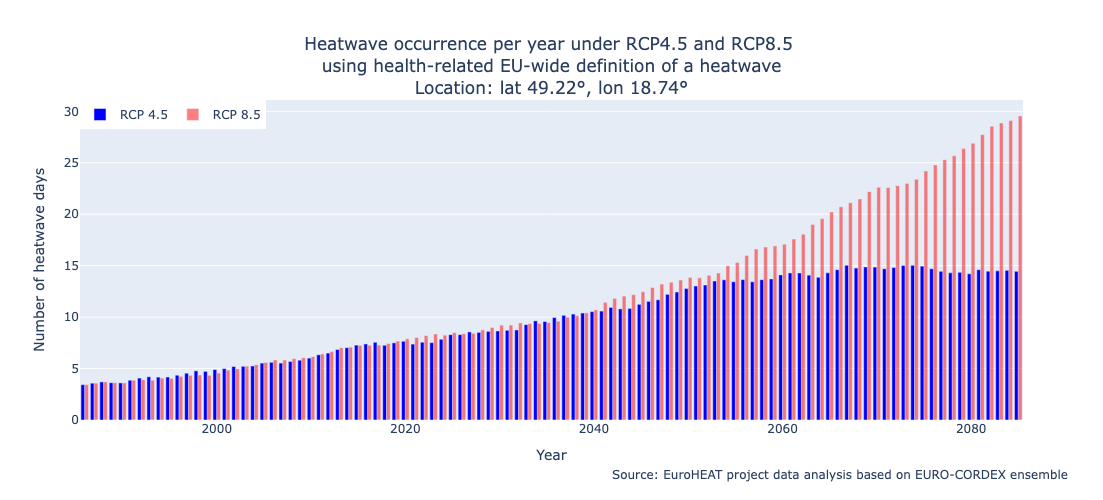

In [24]:
b = hwd45h
t = hwd85h

# Define years
year = list(range(1986, 2086))

# Create figure
fig = go.Figure()
# Add bar trace for 'b'
fig.add_trace(go.Bar(x=year, y=b, name='RCP 4.5', marker_color='blue'))
# Add bar trace for 't'
fig.add_trace(go.Bar(x=year, y=t, name='RCP 8.5', opacity=0.5, marker_color='red'))

# Add information on source data
fig.add_annotation(xref='paper',yref='paper', y=-0.2,x=1.05, showarrow=False,
            text=f'Source: EuroHEAT project data analysis based on EURO-CORDEX ensemble')

# Update layout
fig.update_layout(
    title={'text':f'Heatwave occurrence per year under RCP4.5 and RCP8.5 <br>using health-related EU-wide definition of a heatwave<br>Location: lat {lat:.02f}\u00B0, lon {lon:.02f}\u00B0','x':0.5,'xanchor': 'center'},
    xaxis_title='Year',
    yaxis_title='Number of heatwave days',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    width=1100,
    height=500
)
fig.show()

The graph above shows the yearly heatwave occurrence for the selected location for 1986-2086 for RCP4.5 and RCP8.5.  
These results are based on the EU-wide **heatlh-related** thresholds in the heatwave definition as used in the EuroHEAT project [[source](https://confluence.ecmwf.int/display/CKB/Heat+waves+and+cold+spells+in+Europe+derived+from+climate+projections+documentation)].

The regression curve is plotted with the [standard error](https://blog.minitab.com/en/adventures-in-statistics-2/regression-analysis-how-to-interpret-s-the-standard-error-of-the-regression) around the line.

### Plot results for heatwaves defined using national thresholds

The heatwave data calculated using national heatwave definitions is only available for a few states in the EU (Belgium, Hungary, Italy, United Kingdom, Sweden, Lithuania, Latvia, Estonia, Finland).

In [25]:
if not any(np.isnan(hwd45n)): # check if there is national data for the previously selected location
    # Define years
    year = list(range(1986, 2086))

    # Create figure
    fig = go.Figure()
    # Add bar trace for 'b'
    fig.add_trace(go.Bar(x=year, y=b, name='RCP 4.5', marker_color='blue'))
    # Add bar trace for 't'
    fig.add_trace(go.Bar(x=year, y=t, name='RCP 8.5', opacity=0.5, marker_color='red'))
    # Update layout
    fig.update_layout(
        title={'text':f'Heatwave occurrence per year under RCP4.5 and RCP8.5 <br>using national definition of a heatwave<br>Location: lat {lat:.02f}\u00B0, lon {lon:.02f}\u00B0','x':0.5,'xanchor': 'center'},
        xaxis_title='Year',
        yaxis_title='Number of heatwave days',
        legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
        width=1100,
        height=500
    )
    fig.show()
else:
    print("No data is available for this location based on national heatwave definition.")

No data is available for this location based on national heatwave definition.


The graph above shows the heatwave occurrence for the selected location for 1986-2086 for RCP4.5 and RCP8.5.
These results are based on the **national** thresholds for defining a heatwave, based on the EuroHEAT project [[source](https://confluence.ecmwf.int/display/CKB/Heat+waves+and+cold+spells+in+Europe+derived+from+climate+projections+documentation)].

## Conclusion for the hazard assessment result based on EuroHEAT 

- The results show the projected heatwave occurrence per year. We can plot the results based on the health-related thresholds or national thresholds for the heatwave definition. 
- The health-related data are available for the whole EU, but the national-related data are available only for a few EU states.
- The workflow allows to evaluate the projected trend in the heat wave occurence over time under two climate change scenarios at a local resolution of 12 x 12 km. Please note that this data does not include the urban heat-island effect and therefore is not fully representative for urban environments. Extra corrections for urban locations are necessary to include the increased temperatures within built environment.

## Authors 

Main contributors:
- Martin Kuban, KAJO services (martin.kuban@kajoservices.com)
- Milan Kalas, KAJO services (milan.kalas@kajoservices.com)
- Milica Aleksic, KAJO services (milica.aleksic@kajoservices.com)
- Natalia Aleksandrova (review and editing)